In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [ ]:
# Let's make a dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


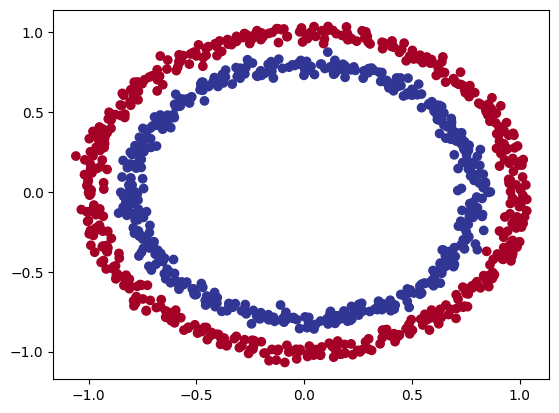

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap = plt.cm.RdYlBu
            )

In [ ]:
import torch
torch.__version__

'2.1.0+cu121'

In [ ]:
type(X)

numpy.ndarray

In [ ]:
# Turn data into tensors

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Model

Let's build a model to classify our blue and red dots.

To do so, we want to:

1. Setup device agnostic code so that our code will run on accelerator (GPU) if there is one.
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now that we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data.
3. Define a `forward()` method that outlines the forward pass.
4. Instantiate an instance of our model class and send it to the target `device`

In [ ]:
# 1. Constructing a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Creating 2 Linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales it to 5.
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from the previous layers and outputs 1 feature becuase that's the dimension of y.

  # 3. forward method
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

# 4. Instantiating an instance of our model class and sending it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cpu'

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

In [ ]:
# replicating the above model using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0567, -0.4346],
                      [ 0.1224, -0.2464],
                      [-0.4188, -0.2012],
                      [-0.2424,  0.4991],
                      [ 0.6833,  0.2514]])),
             ('0.bias', tensor([ 0.3478,  0.4219, -0.1902, -0.5760,  0.2092])),
             ('1.weight',
              tensor([[-0.2694,  0.0248,  0.0161, -0.1714, -0.0572]])),
             ('1.bias', tensor([0.4131]))])

### 2.1 Setup loss function and optimizer

Choosing a loss function is problem specific and usually for regression you might want to use MAE(L1) or MSE. Whereas for classification tasks you might want to use Binary Cross Entropy Loss (Binary Classification) or Categorical Cross Entropy Loss (Multiclass Classification).

In [ ]:
# Setup Loss function
# loss_fn = nn.BCELoss() # BCELoss requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has a sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_true)) * 100
  return acc

## 3.1 Going from raw logits to prediction probabilities

Our model ouputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.


In [ ]:
# View the first 5 outputs of the forward pass on the test data.

model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0332],
        [-0.0208],
        [ 0.1107],
        [ 0.0115],
        [ 0.0088]])

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs, y_pred_probs.shape

(tensor([[0.5083],
         [0.4948],
         [0.5276],
         [0.5029],
         [0.5022]]),
 torch.Size([5, 1]))

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)
# print(y_preds.squeeze().shape)
# raise

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
# print(y_preds.squeeze().shape)
# raise

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


In [ ]:
### 3.2 Building a training and testing loop
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  # print(y_logits.shape)
  # raise

  y_preds = torch.round(torch.sigmoid(y_logits))
  # print(y_pred_probs.shape)
  # raise
  # y_preds = torch.round(y_pred_probs)

  train_loss = loss_fn(y_logits, y_train) # y_logits because we are using the loss function BCEWithLogitsLoss() and it take the input as logits and we are using this loss function because it provides numerical stability.

  acc = accuracy_fn(y_true=y_train, y_pred = y_preds)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

  if epoch%10 == 0:
    print(f"Epoch: {epoch+1}/{epochs} | Train loss: {train_loss:.5f}, Train acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 1/100 | Train loss: 0.69302, Train acc: 50.38% | Test loss: 0.69413, Test acc: 46.00%
Epoch: 11/100 | Train loss: 0.69301, Train acc: 51.00% | Test loss: 0.69418, Test acc: 45.00%
Epoch: 21/100 | Train loss: 0.69301, Train acc: 50.50% | Test loss: 0.69422, Test acc: 46.00%
Epoch: 31/100 | Train loss: 0.69300, Train acc: 50.88% | Test loss: 0.69426, Test acc: 47.00%
Epoch: 41/100 | Train loss: 0.69300, Train acc: 50.50% | Test loss: 0.69430, Test acc: 45.50%
Epoch: 51/100 | Train loss: 0.69300, Train acc: 50.50% | Test loss: 0.69433, Test acc: 46.00%
Epoch: 61/100 | Train loss: 0.69299, Train acc: 50.88% | Test loss: 0.69436, Test acc: 46.50%
Epoch: 71/100 | Train loss: 0.69299, Train acc: 50.75% | Test loss: 0.69439, Test acc: 48.00%
Epoch: 81/100 | Train loss: 0.69299, Train acc: 51.12% | Test loss: 0.69441, Test acc: 47.50%
Epoch: 91/100 | Train loss: 0.69299, Train acc: 51.00% | Test loss: 0.69444, Test acc: 47.50%


## 4. Make predictions and evaluate the model.

From the metrics it looks like our model isn't learning anything ...
(I believe it is because we did not use any non linear activation functions)

In [ ]:
# import requests
# from pathlib import Path

# if Path("helper_functions.py").is_file():
#   print("helper_functions.py already exists, skipping download")
# else:
#   print("Downloading helper_functions.py")
#   request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
#   with open("helper_functions.py", "wb") as f:
#     f.write(request.content)

# from helper_functions import plot_predictions, plot_decision_boundary


In [ ]:
# 1. Constructing a model that subclasses nn.Module
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Creating 2 Linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=8) # takes in 2 features and upscales it to 5.
    self.layer_2 = nn.Linear(in_features=8, out_features=8) # takes in 5 features from the previous layers and outputs 1 feature becuase that's the dimension of y.
    self.layer_3 = nn.Linear(in_features=8, out_features=1)
    self.relu = nn.ReLU()

  # 3. forward method
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# 4. Instantiating an instance of our model class and sending it to the target device
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4830, -0.5999],
                      [-0.3894, -0.6189],
                      [-0.4502,  0.7068],
                      [ 0.1336,  0.2179],
                      [-0.6595, -0.4644],
                      [-0.2354,  0.1106],
                      [-0.6222, -0.3047],
                      [-0.4233,  0.0020]])),
             ('layer_1.bias',
              tensor([-0.2631, -0.0490, -0.4792, -0.4854, -0.4125, -0.2420, -0.5581,  0.5929])),
             ('layer_2.weight',
              tensor([[-0.0702,  0.3042,  0.1102, -0.2994,  0.2447, -0.0973, -0.1355, -0.2935],
                      [-0.3515,  0.1012, -0.0772,  0.1376, -0.2901,  0.2625, -0.2595, -0.0610],
                      [ 0.0738,  0.1825,  0.2854,  0.3221, -0.2803,  0.0890, -0.1521, -0.0387],
                      [-0.2646,  0.3220, -0.2595,  0.1890,  0.1243,  0.1149, -0.1911,  0.3214],
                      [ 0.0777,  0.0455, -0.3116,  0.1484, -0.0530, -0.1620,  0.3037, 

In [ ]:
# Setup Loss function
# loss_fn = nn.BCELoss() # BCELoss requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has a sigmoid activation function built-in

optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
### 3.2 Building a training and testing loop
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  # print(y_logits.shape)
  # raise

  y_preds = torch.round(torch.sigmoid(y_logits))
  # print(y_pred_probs.shape)
  # raise
  # y_preds = torch.round(y_pred_probs)

  train_loss = loss_fn(y_logits, y_train) # y_logits because we are using the loss function BCEWithLogitsLoss() and it take the input as logits and we are using this loss function because it provides numerical stability.

  acc = accuracy_fn(y_true=y_train, y_pred = y_preds)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

  if epoch%10 == 0:
    print(f"Epoch: {epoch+1}/{epochs} | Train loss: {train_loss:.5f}, Train acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 1/100 | Train loss: 0.00036, Train acc: 100.00% | Test loss: 0.00409, Test acc: 100.00%
Epoch: 11/100 | Train loss: 0.00035, Train acc: 100.00% | Test loss: 0.00416, Test acc: 100.00%
Epoch: 21/100 | Train loss: 0.00034, Train acc: 100.00% | Test loss: 0.00429, Test acc: 100.00%
Epoch: 31/100 | Train loss: 0.00034, Train acc: 100.00% | Test loss: 0.00435, Test acc: 100.00%
Epoch: 41/100 | Train loss: 0.00033, Train acc: 100.00% | Test loss: 0.00454, Test acc: 100.00%
Epoch: 51/100 | Train loss: 0.00032, Train acc: 100.00% | Test loss: 0.00459, Test acc: 100.00%
Epoch: 61/100 | Train loss: 0.00032, Train acc: 100.00% | Test loss: 0.00473, Test acc: 100.00%
Epoch: 71/100 | Train loss: 0.00031, Train acc: 100.00% | Test loss: 0.00485, Test acc: 100.00%
Epoch: 81/100 | Train loss: 0.00030, Train acc: 100.00% | Test loss: 0.00494, Test acc: 100.00%
Epoch: 91/100 | Train loss: 0.00030, Train acc: 100.00% | Test loss: 0.00520, Test acc: 100.00%


In [ ]:
A = torch.arange(-10, 10)
A

tensor([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9])

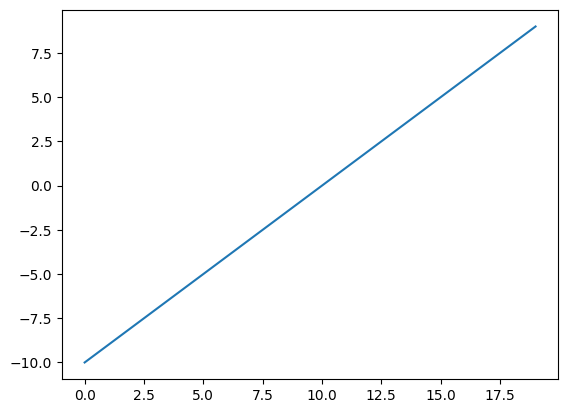

In [ ]:
plt.plot(A)

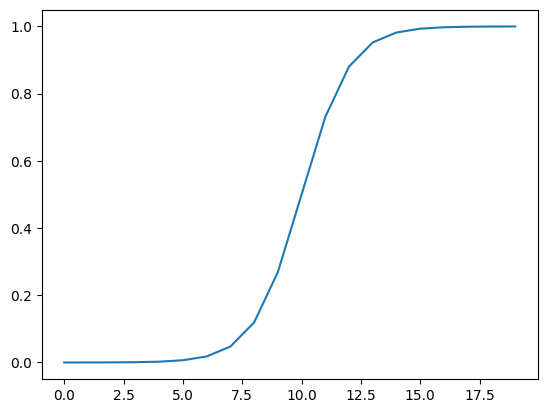

In [ ]:
plt.plot(torch.sigmoid(A))

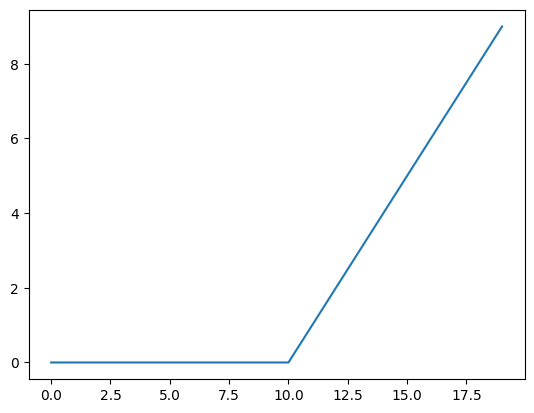

In [ ]:
plt.plot(torch.relu(A))

## 8. Putting it all together with a multi-class classification problem

### 8.1 Creating a toy multi-class dataset

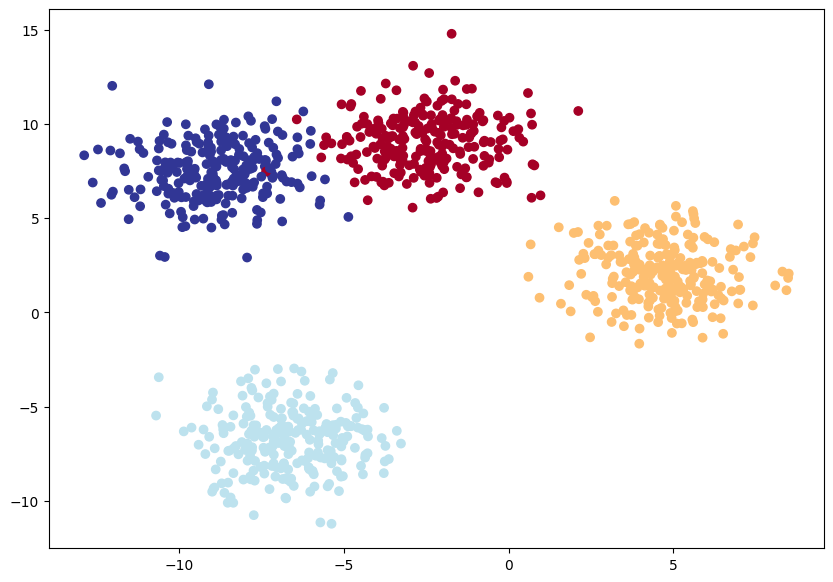

In [ ]:
# 1. import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_SAMPLES = 1000
NUM_FEATURES = 2
NUM_CLASSES = 4
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# Converting dataset from numpy to tensors
X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)

# Creating splits in dataset
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# print(X_blob_train.dtype  )

# Visulaizing the dataset
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Building a multi-class classifictaion model
class BlobModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_size=8):
    super().__init__()

    self.stack_layers = nn.Sequential(nn.Linear(in_features=in_features,
                                                out_features=hidden_size),
                                      nn.ReLU(),
                                      nn.Linear(hidden_size, hidden_size),
                                      nn.ReLU(),
                                      nn.Linear(hidden_size, out_features))

  def forward(self, x):
    return self.stack_layers(x)

# Create model instance and send it to target device
model_2 = BlobModel(in_features=2,
                    out_features=4,
                    hidden_size=8)
model_2

BlobModel(
  (stack_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimizer for multi-class classification

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.01)

### 8.4 Getting prediction probabilities for multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the predicted probabilities)

In [ ]:
model_2.eval()
with torch.inference_mode():
  y_logits = model_2(X_blob_test.to(device))
  # print(y_logits)
  # print(y_blob_test)

y_logits[:10]

tensor([[-0.1918,  0.0793, -0.3977,  0.0698],
        [-1.0829,  0.0888, -0.1019, -0.8649],
        [-0.1488,  0.6883,  0.8175,  0.1347],
        [-0.1744,  0.0060, -0.3703,  0.1615],
        [-0.7600,  0.0421, -0.5652, -0.4514],
        [-1.2423,  0.1086, -0.0630, -1.0634],
        [-0.1787,  0.8435,  0.9319,  0.0764],
        [-0.8615,  0.0244, -0.3904, -0.5838],
        [-0.1119,  0.5706,  0.7521,  0.1776],
        [-0.8304,  0.0225, -0.4394, -0.5460]])

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

### 8.5 Creating a training and testing loop for a multi-class PyTorch model.

In [ ]:
epochs = 100

X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_2.train()

  y_logits = model_2(X_blob_train)
  y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
  # print(y_logits.shape, y_blob_train.shape)
  # raise

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    y_test_logits = model_2(X_blob_test)
    y_test_preds = torch.argmax(torch.softmax(y_test_logits, dim=1), dim=1)

    test_loss = loss_fn(y_test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=y_test_preds)

  if epoch%10==0:
    print(f"Epoch: {epoch}/{epochs} | Training loss: {loss:.4f}, Training acc: {acc:.2f} | Testing loss: {test_loss:.4f}, Testing acc:{test_acc:.2f}")

Epoch: 0/100 | Training loss: 0.0235, Training acc: 99.25 | Testing loss: 0.0130, Testing acc:99.50
Epoch: 10/100 | Training loss: 0.0230, Training acc: 99.25 | Testing loss: 0.0126, Testing acc:99.50
Epoch: 20/100 | Training loss: 0.0226, Training acc: 99.25 | Testing loss: 0.0121, Testing acc:99.50
Epoch: 30/100 | Training loss: 0.0223, Training acc: 99.25 | Testing loss: 0.0116, Testing acc:99.50
Epoch: 40/100 | Training loss: 0.0219, Training acc: 99.25 | Testing loss: 0.0113, Testing acc:99.50
Epoch: 50/100 | Training loss: 0.0216, Training acc: 99.25 | Testing loss: 0.0109, Testing acc:99.50
Epoch: 60/100 | Training loss: 0.0214, Training acc: 99.25 | Testing loss: 0.0106, Testing acc:99.50
Epoch: 70/100 | Training loss: 0.0211, Training acc: 99.25 | Testing loss: 0.0103, Testing acc:99.50
Epoch: 80/100 | Training loss: 0.0209, Training acc: 99.38 | Testing loss: 0.0100, Testing acc:99.50
Epoch: 90/100 | Training loss: 0.0206, Training acc: 99.50 | Testing loss: 0.0098, Testing a